In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import PMF

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
get_target = lambda df: (df['duration'].values, df['event'].values)

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

num_durations = 10

labtrans = PMF.label_transform(num_durations)

y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))

train = (x_train, y_train)
val = (x_test, y_test)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Neural Network

In [37]:
in_features = x_train.shape[1]
num_nodes = [16,8]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=70)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = PMF(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.7830,	val_loss: 1.6716
1:	[0s / 0s],		train_loss: 1.5738,	val_loss: 1.4584
2:	[0s / 0s],		train_loss: 1.4997,	val_loss: 1.3879
3:	[0s / 0s],		train_loss: 1.5263,	val_loss: 1.3498
4:	[0s / 0s],		train_loss: 1.4555,	val_loss: 1.3236
5:	[0s / 0s],		train_loss: 1.4961,	val_loss: 1.3170
6:	[0s / 0s],		train_loss: 1.4436,	val_loss: 1.3103
7:	[0s / 0s],		train_loss: 1.4571,	val_loss: 1.2995
8:	[0s / 0s],		train_loss: 1.3916,	val_loss: 1.2792
9:	[0s / 0s],		train_loss: 1.3910,	val_loss: 1.2740
10:	[0s / 0s],		train_loss: 1.4421,	val_loss: 1.2748
11:	[0s / 0s],		train_loss: 1.4322,	val_loss: 1.2763
12:	[0s / 0s],		train_loss: 1.3893,	val_loss: 1.2817
13:	[0s / 0s],		train_loss: 1.3453,	val_loss: 1.2802
14:	[0s / 0s],		train_loss: 1.3500,	val_loss: 1.2749
15:	[0s / 0s],		train_loss: 1.3624,	val_loss: 1.2682
16:	[0s / 0s],		train_loss: 1.3714,	val_loss: 1.2617
17:	[0s / 0s],		train_loss: 1.3126,	val_loss: 1.2558
18:	[0s / 0s],		train_loss: 1.3353,	val_loss: 1.2602
19:

0.6803488968701898

<Figure size 864x864 with 0 Axes>

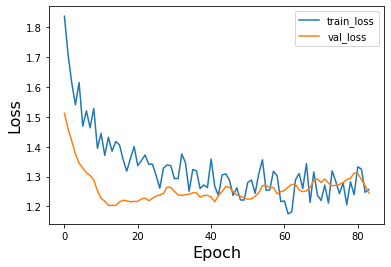

In [49]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.17527113363143262

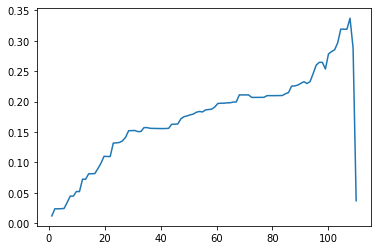

In [39]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [40]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6219045797877426

0.37758840948470856

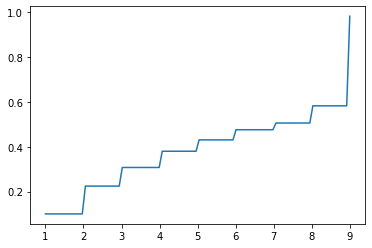

In [41]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [43]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.625062620926107
The C-index Low 95% CI:0.6226711572332492
The C-index High 95% CI:0.6274540846189648


In [44]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5856762868324988
The C-index Low 95% CI:0.582826020062079
The C-index High 95% CI:0.5885265536029187


In [45]:
model_cox.save_model_weights('myweights_PMF.pt')

# LASSO var

In [46]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [47]:
# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [48]:
in_features = x_train.shape[1]
num_nodes = [16,8]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=70)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = PMF(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.8370,	val_loss: 1.5121
1:	[0s / 0s],		train_loss: 1.7079,	val_loss: 1.4595
2:	[0s / 0s],		train_loss: 1.6136,	val_loss: 1.4194
3:	[0s / 0s],		train_loss: 1.5407,	val_loss: 1.3751
4:	[0s / 0s],		train_loss: 1.6148,	val_loss: 1.3450
5:	[0s / 0s],		train_loss: 1.4689,	val_loss: 1.3282
6:	[0s / 0s],		train_loss: 1.5202,	val_loss: 1.3127
7:	[0s / 0s],		train_loss: 1.4631,	val_loss: 1.3036
8:	[0s / 0s],		train_loss: 1.5285,	val_loss: 1.2883
9:	[0s / 0s],		train_loss: 1.3944,	val_loss: 1.2526
10:	[0s / 0s],		train_loss: 1.4444,	val_loss: 1.2267
11:	[0s / 0s],		train_loss: 1.3711,	val_loss: 1.2175
12:	[0s / 0s],		train_loss: 1.4314,	val_loss: 1.2036
13:	[0s / 0s],		train_loss: 1.3845,	val_loss: 1.2033
14:	[0s / 0s],		train_loss: 1.4173,	val_loss: 1.2039
15:	[0s / 0s],		train_loss: 1.4066,	val_loss: 1.2148
16:	[0s / 0s],		train_loss: 1.3572,	val_loss: 1.2203
17:	[0s / 0s],		train_loss: 1.3180,	val_loss: 1.2188
18:	[0s / 0s],		train_loss: 1.3602,	val_loss: 1.2153
19:

0.6803488968701898

<Figure size 864x864 with 0 Axes>

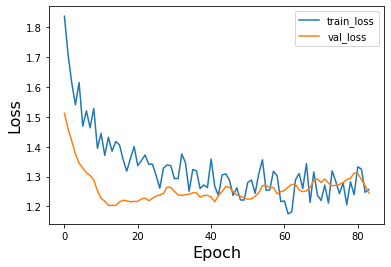

In [50]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.16533334171537387

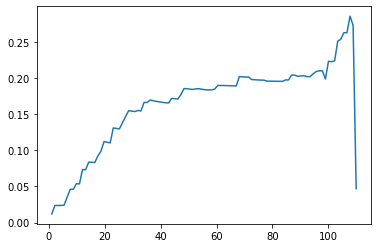

In [51]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [52]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.5425470886318003

0.3834071120581399

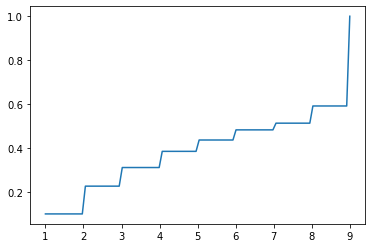

In [72]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [53]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5450544918943583
The C-index Low 95% CI:0.5424172644936115
The C-index High 95% CI:0.5476917192951051


In [54]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.583213550383759
The C-index Low 95% CI:0.5804412432104371
The C-index High 95% CI:0.5859858575570809


# TNM

In [55]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [57]:
# to standardize and get dependent variables 
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)

x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [66]:
in_features = x_train.shape[1]
num_nodes = [32,16]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=70)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = PMF(net, tt.optim.Adam(lr=0.01,amsgrad=True), duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.7998,	val_loss: 1.5327
1:	[0s / 0s],		train_loss: 1.6012,	val_loss: 1.4193
2:	[0s / 0s],		train_loss: 1.5330,	val_loss: 1.3321
3:	[0s / 0s],		train_loss: 1.5973,	val_loss: 1.2859
4:	[0s / 0s],		train_loss: 1.4724,	val_loss: 1.2674
5:	[0s / 0s],		train_loss: 1.4574,	val_loss: 1.2597
6:	[0s / 0s],		train_loss: 1.4232,	val_loss: 1.2552
7:	[0s / 0s],		train_loss: 1.3927,	val_loss: 1.2558
8:	[0s / 0s],		train_loss: 1.4056,	val_loss: 1.2507
9:	[0s / 0s],		train_loss: 1.3628,	val_loss: 1.2454
10:	[0s / 0s],		train_loss: 1.3148,	val_loss: 1.2486
11:	[0s / 0s],		train_loss: 1.3329,	val_loss: 1.2436
12:	[0s / 0s],		train_loss: 1.3473,	val_loss: 1.2418
13:	[0s / 0s],		train_loss: 1.3119,	val_loss: 1.2351
14:	[0s / 0s],		train_loss: 1.3572,	val_loss: 1.2291
15:	[0s / 0s],		train_loss: 1.3536,	val_loss: 1.2359
16:	[0s / 0s],		train_loss: 1.3682,	val_loss: 1.2314
17:	[0s / 0s],		train_loss: 1.3546,	val_loss: 1.2199
18:	[0s / 0s],		train_loss: 1.3590,	val_loss: 1.2281
19:

0.6605951770138533

<Figure size 864x864 with 0 Axes>

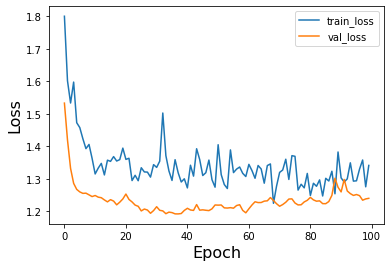

In [67]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.1752205101824531

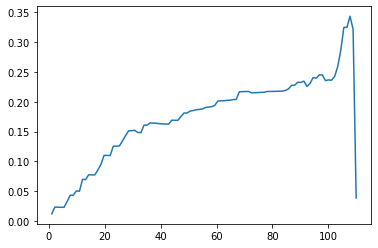

In [68]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [69]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.5163854096949996

0.3834071120581399

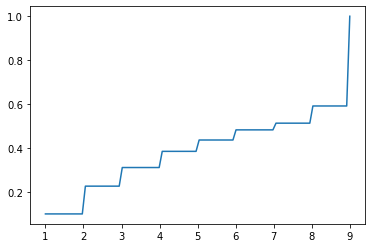

In [73]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [70]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.5180986496918859
The C-index Low 95% CI:0.5154070773222498
The C-index High 95% CI:0.520790222061522


In [71]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.5233443907985931
The C-index Low 95% CI:0.5198082797317657
The C-index High 95% CI:0.5268805018654205
